# Overview of Graph Analysis and Visualization Tools in Cytoscape/Notebook Ecosystem

![title](https://www.timlrx.com/_next/image?url=%2Fstatic%2Fimg%2Fgraph_libraries.png&w=3840&q=75)

[(Image from this page)](https://www.timlrx.com/blog/benchmark-of-popular-graph-network-packages-v2)

### Lab Meeting (1/26/2022)
Keiichiro Ono: Ideker Lab Software Team kono@ucsd.edu

# TL;DR (Summary / take-home messages)
- There is no "one-size-fits-all" solution for biological network analysis and visualization
    - Combination of multiple tools/libraries is necessary
    - You need to use multiple tools for data wrangling and conversion
- Use efficient library optimized for multi-core environment
- Interacvtive style editing in notebook environment is desirable, but not available (yet)
- Because of these small, but annoying barriers/problems, there is room for new small toolkits
    - Interactive style editor in the notebook environment
    - _True_ portable network style format
        - Believe or not, there is no such thing in network visualization data formats
- Plotly Dash ecosystem is a great way to create simple dashboard, or even web applications for publication
    - No JavaScript/TypeScript coding is required to create simple data dashboard

# Theme: Network visualization workflow without the desktop application
**What does the workflow look like if we fully move to the web (service-based) environment?**

----

## Important Notice: this is a survey, not a final product from our team

----

# Background

### Software team is still in the middle of the transition from desktop-application-centric world to the web-based ecosystem for biological network analysis and visualization.

This presentation is a **survay / tutorial** of extinting tools and libraries available now and discuss missing pieces to build easy-to-use pipeline for network visualization.

- We need to support both:
    - Casual users
    - Advanced users (bioinformaticians)
        - Analyze graph structure with scripts
        - Implement new algorithms on top of existing graph libraries
- **This workflow is for advanced users who can write some Python code**

## Topics Covered

#### This presentation is for Python ecosystem only
(R/Julia/Rust/JS has different toolchains, and maybe covered in future tutorial sessions)

- Search & import data directly from NDEx
- Convert CX to popular libraries' data formats
- Analyze network with some popular libraries
- Visualization
    - Static (publication-ready) images
    - Interactive cells
    - Rapid dashboard development

## Tools and Libraries
- [NDEx2 Python client](https://ndex2.readthedocs.io/en/latest/)
- [JupyterLab](https://jupyterlab.readthedocs.io/en/stable/) workbench
- Graph analysis toolkits
    - [NetworkX](https://networkx.org/)
    - [graph-tool](https://graph-tool.skewed.de/)
    - [igraph](https://igraph.org/)
    - [Networkit](https://networkit.github.io/)
- Interactive Visualization
    - [ipycytoscape](https://ipycytoscape.readthedocs.io/en/latest/)
    - Plotly [Dash](https://dash.plotly.com/), [JupyterDash](https://medium.com/plotly/introducing-jupyterdash-811f1f57c02e), and [Dash Cytoscape](https://dash.plotly.com/cytoscape)

# This is a VERY brief introduction
If you use combination of these tools, you can automate the large graph analysis / visualization workflow without leaving the notebook.

----

## Hands-on Tutorial

- Install [Docker Desktop](https://www.docker.com/products/docker-desktop)
- Clone / download this repository
- Run the following command to start notebook

> docker-compose up

![](images/how_this_works.png)

### Note: Cytoscape Desktop will NOT be used in this example

----

In [1]:
# Check Python version (this workflow is for 3.x only)
!python3 --version

Python 3.9.5


## Dependencies

This Docker image contains a lot of libraries. You can install these directly into your laptop, but I recommend to use the container for now (some of the libraries are bit tricky to install)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import networkit as nk

from graph_tool.all import *

import json
import ndex2

import ipycytoscape

import ipywidgets as widgets

import networkx as nx

import ipywidgets as widgets

import numpy as np
import pandas as pd
import seaborn as sns

Unable to init server: Could not connect: Connection refused
Unable to init server: Could not connect: Connection refused


# 1. Data Import from NDEx

## NDEx2 Python client

You can use _ndex2_ Python client library for directly fetching network data from [NDEx](https://www.ndexbio.org)

### Search NDEx database
(You can skip this step if you already have network data)

- If you want to batch-process networks in NDEx server, you can use this client to search & fetch data in CX
- There are amy ways to get networks you need.  Please referer the documentation for more details

#### Potential new tool idea
 - Higher-level utility funciton for search & filter the search results? 

In [3]:
# Create NDEx2 python client
nc2 = ndex2.client.Ndex2()

# Search COVID-related networks using free-keyword
response1 = nc2.search_networks('covid*')
print('Found: ' + str(response1['numFound']) + ' entries')

Found: 75 entries


In [4]:
# Filter & sort the result (networks with more than 500 edges)
MIN_EGDE_COUNT = 100

networks = response1['networks']
large_networks = filter(lambda net: net['edgeCount'] > MIN_EGDE_COUNT, networks)
lg_sorted = sorted(large_networks, key=lambda net: int(net['edgeCount']))

# Display the result (name, size, and UUID)
for net in lg_sorted:
    print(net['name'] + ': (node, edge) = (' + str(net['nodeCount']) + ', ' + str(net['edgeCount']) + ') ' + net['externalId'])

Fig.S7. SARS-CoV-2 Nsp16 Virus-Host Protein Interaction Network. : (node, edge) = (58, 103) 8474c7e5-22b6-11eb-9e72-0ac135e8bacf
Phosphorylation on SARS-CoV-2 Virus-Human Interacting Proteins: (node, edge) = (136, 117) ecc4a983-56b6-11eb-9e72-0ac135e8bacf
Fig.5. Community detection from transcriptomic/PPI integrated data in SARS-CoV-2-infected lung epithelial cells: (node, edge) = (131, 143) 7cde963a-dc09-11ea-8772-0ac135e8bacf
SARS-CoV-2/Human interactome: (node, edge) = (125, 206) 296dd114-d392-11ea-8772-0ac135e8bacf
The SARS-CoV-2-perturbed network.: (node, edge) = (130, 305) 25708de8-f1b1-11ea-99da-0ac135e8bacf
COVID-19 Causal Network: (node, edge) = (155, 311) 60ad63e1-f3a9-11ea-99da-0ac135e8bacf
Coronavirus Proteases Sequence Similarity Network (SSN): (node, edge) = (57, 341) 91376f5c-e62c-11ea-99da-0ac135e8bacf
ACE2_network: (node, edge) = (69, 368) c5c336c2-9ab3-11ea-aaef-0ac135e8bacf
The COVID-19 patient-specific individual network.: (node, edge) = (127, 412) e6e86f53-f1ad-11e

## Fetch data from NDEx


In [5]:
# Pick one of the results
COVID_PPI_UUID = lg_sorted[0]['externalId']

# Download BioGRID: Protein-Protein Interactions (SARS-CoV) from NDEx
response1 = nc2.get_network_as_cx_stream(COVID_PPI_UUID)

# Convert downloaded network to NiceCXNetwork object
cov_cx = ndex2.create_nice_cx_from_raw_cx(json.loads(response1.content))

# Display information about network and output 1st 100 characters of CX
cov_cx.print_summary()

Name: Fig.S7. SARS-CoV-2 Nsp16 Virus-Host Protein Interaction Network. 
Nodes: 58
Edges: 103
Node Attributes: 58
Edge Attributes: 763



## Convert CX to other data formats

- NetworkX
- pandas (Data Frame)
- dot (Graphviz)
- Cytoscape.js

In [6]:
# To pandas dataframe (NDEx2's built-in function)
df1 = cov_cx.to_pandas_dataframe()
df1

,source,interaction,target
0,CEP85L,interacts with,CEP55
1,CEP85L,interacts with,CEP128
2,RNPC3,interacts with,SNRNP48
3,COMMD10,interacts with,COMMD3
4,COMMD10,interacts with,COMMD5
...,...,...,...
98,CCDC93,interacts with,COMMD5
99,CCDC93,interacts with,COMMD6
100,CCDC93,interacts with,COMMD8
101,CCDC93,interacts with,COMMD9


#### It is a good idea to clean / modify the data in this form
- Join other data sets, filter errors, etc.
- There are tons of documentation and utilities to edit your data in pandas
- Once the data is complete, convert to more graph-library-friendly formats (discussed below)

### NertworkX

In [7]:
# Create Networkx network
nx_graph = cov_cx.to_networkx(mode='default')
nx.info(nx_graph)

"MultiDiGraph named 'Fig.S7. SARS-CoV-2 Nsp16 Virus-Host Protein Interaction Network. ' with 58 nodes and 103 edges"

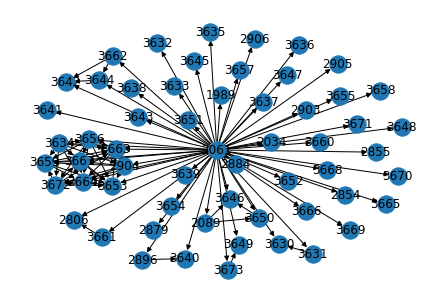

In [8]:
# Draw it with default params
pos = nx.nx_agraph.graphviz_layout(nx_graph, prog='sfdp')
nx.draw(nx_graph, pos=pos, with_labels=True)

#### Pros
- Easy to use
- Well-documented
- Access to many layout algorithms

#### Cons
- **Slow**
- Hard to set complex styling
    - If you are an expert of its API, you can create complex styling, but it is not data-driven

### igraph

In [31]:
# Use NetworkX as a data converter
temp_file_name = 'from_nx.graphml'
nx.write_graphml(nx_graph, temp_file_name)

# Then load it to igraph
from igraph import *
i_graph1 = Graph.Read_GraphML(temp_file_name)

# Simple visualization
layout = i_graph1.layout("kk") # Apply Kamada-Kawai

In [ ]:
# Just an idea: style object to visualziation

style = {

    nodes: {
        color
    }
}

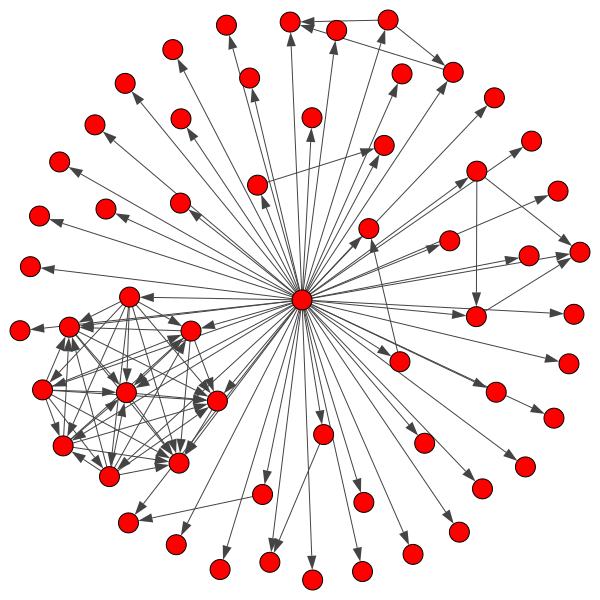

In [31]:
# TODO: Apply style
plot(i_graph1, layout=layout)

#### Pros
- Well-documented
- Access to many graph analysis algorithms
- Fast (core is written in C)

#### Cons
- A bit weired API (from Python programmer's point of view, because it was originally optyimized for R)
- Hard to set complex styling
    - Not data-driven.  You need to write your own mapping functions from data points to visual variables (color, size, shape, etc.)

### graph-tool

### Why graph-tool?
- **MUCH** faster than NetworkX
    - It is simply wast of energy (computing resource) if you use NetworkX in your production code that processes a lot of data (see below)

![comparison](https://github.com/timlrx/graph-benchmarks/blob/master/runtime_results.png?raw=true)

The benchmark above is from [this report](https://www.timlrx.com/blog/benchmark-of-popular-graph-network-packages-v2)

#### Pros
- Well-documented
- Access to many graph analysis algorithms
    - including community detections
- Fast (core is written in C++)
- Optimized for multi-core machines

#### Cons
- VERY hard to install if you install to bare metal machines
    - They recommend to use official docker image
- Has some data-driven preset visualizations, but in most cases, you need to tweak manually

##### Use NetworkX as a graph-format utility library
- NetworkX is VERY slow, but a great format converter
    - It supports:
        - Cytoscape.js format
        - DOT
        - GML
        - GraphML
        - Edge List
        - Pandas Data frame
    - Users can use NetworkX as a format converter for network data sets
    - graph-tool can read standard format like GraphML

In [10]:
# Pick a larger network
COVID_PPI_UUID_L = lg_sorted[20]['externalId']
response2 = nc2.get_network_as_cx_stream(COVID_PPI_UUID_L)
cov_cx2 = ndex2.create_nice_cx_from_raw_cx(json.loads(response2.content))

# Display information about network and output 1st 100 characters of CX
cov_cx2.print_summary()

Name: IMEx/IntAct Coronavirus Dataset, binding regions details
Nodes: 2233
Edges: 4477
Node Attributes: 18035
Edge Attributes: 162047



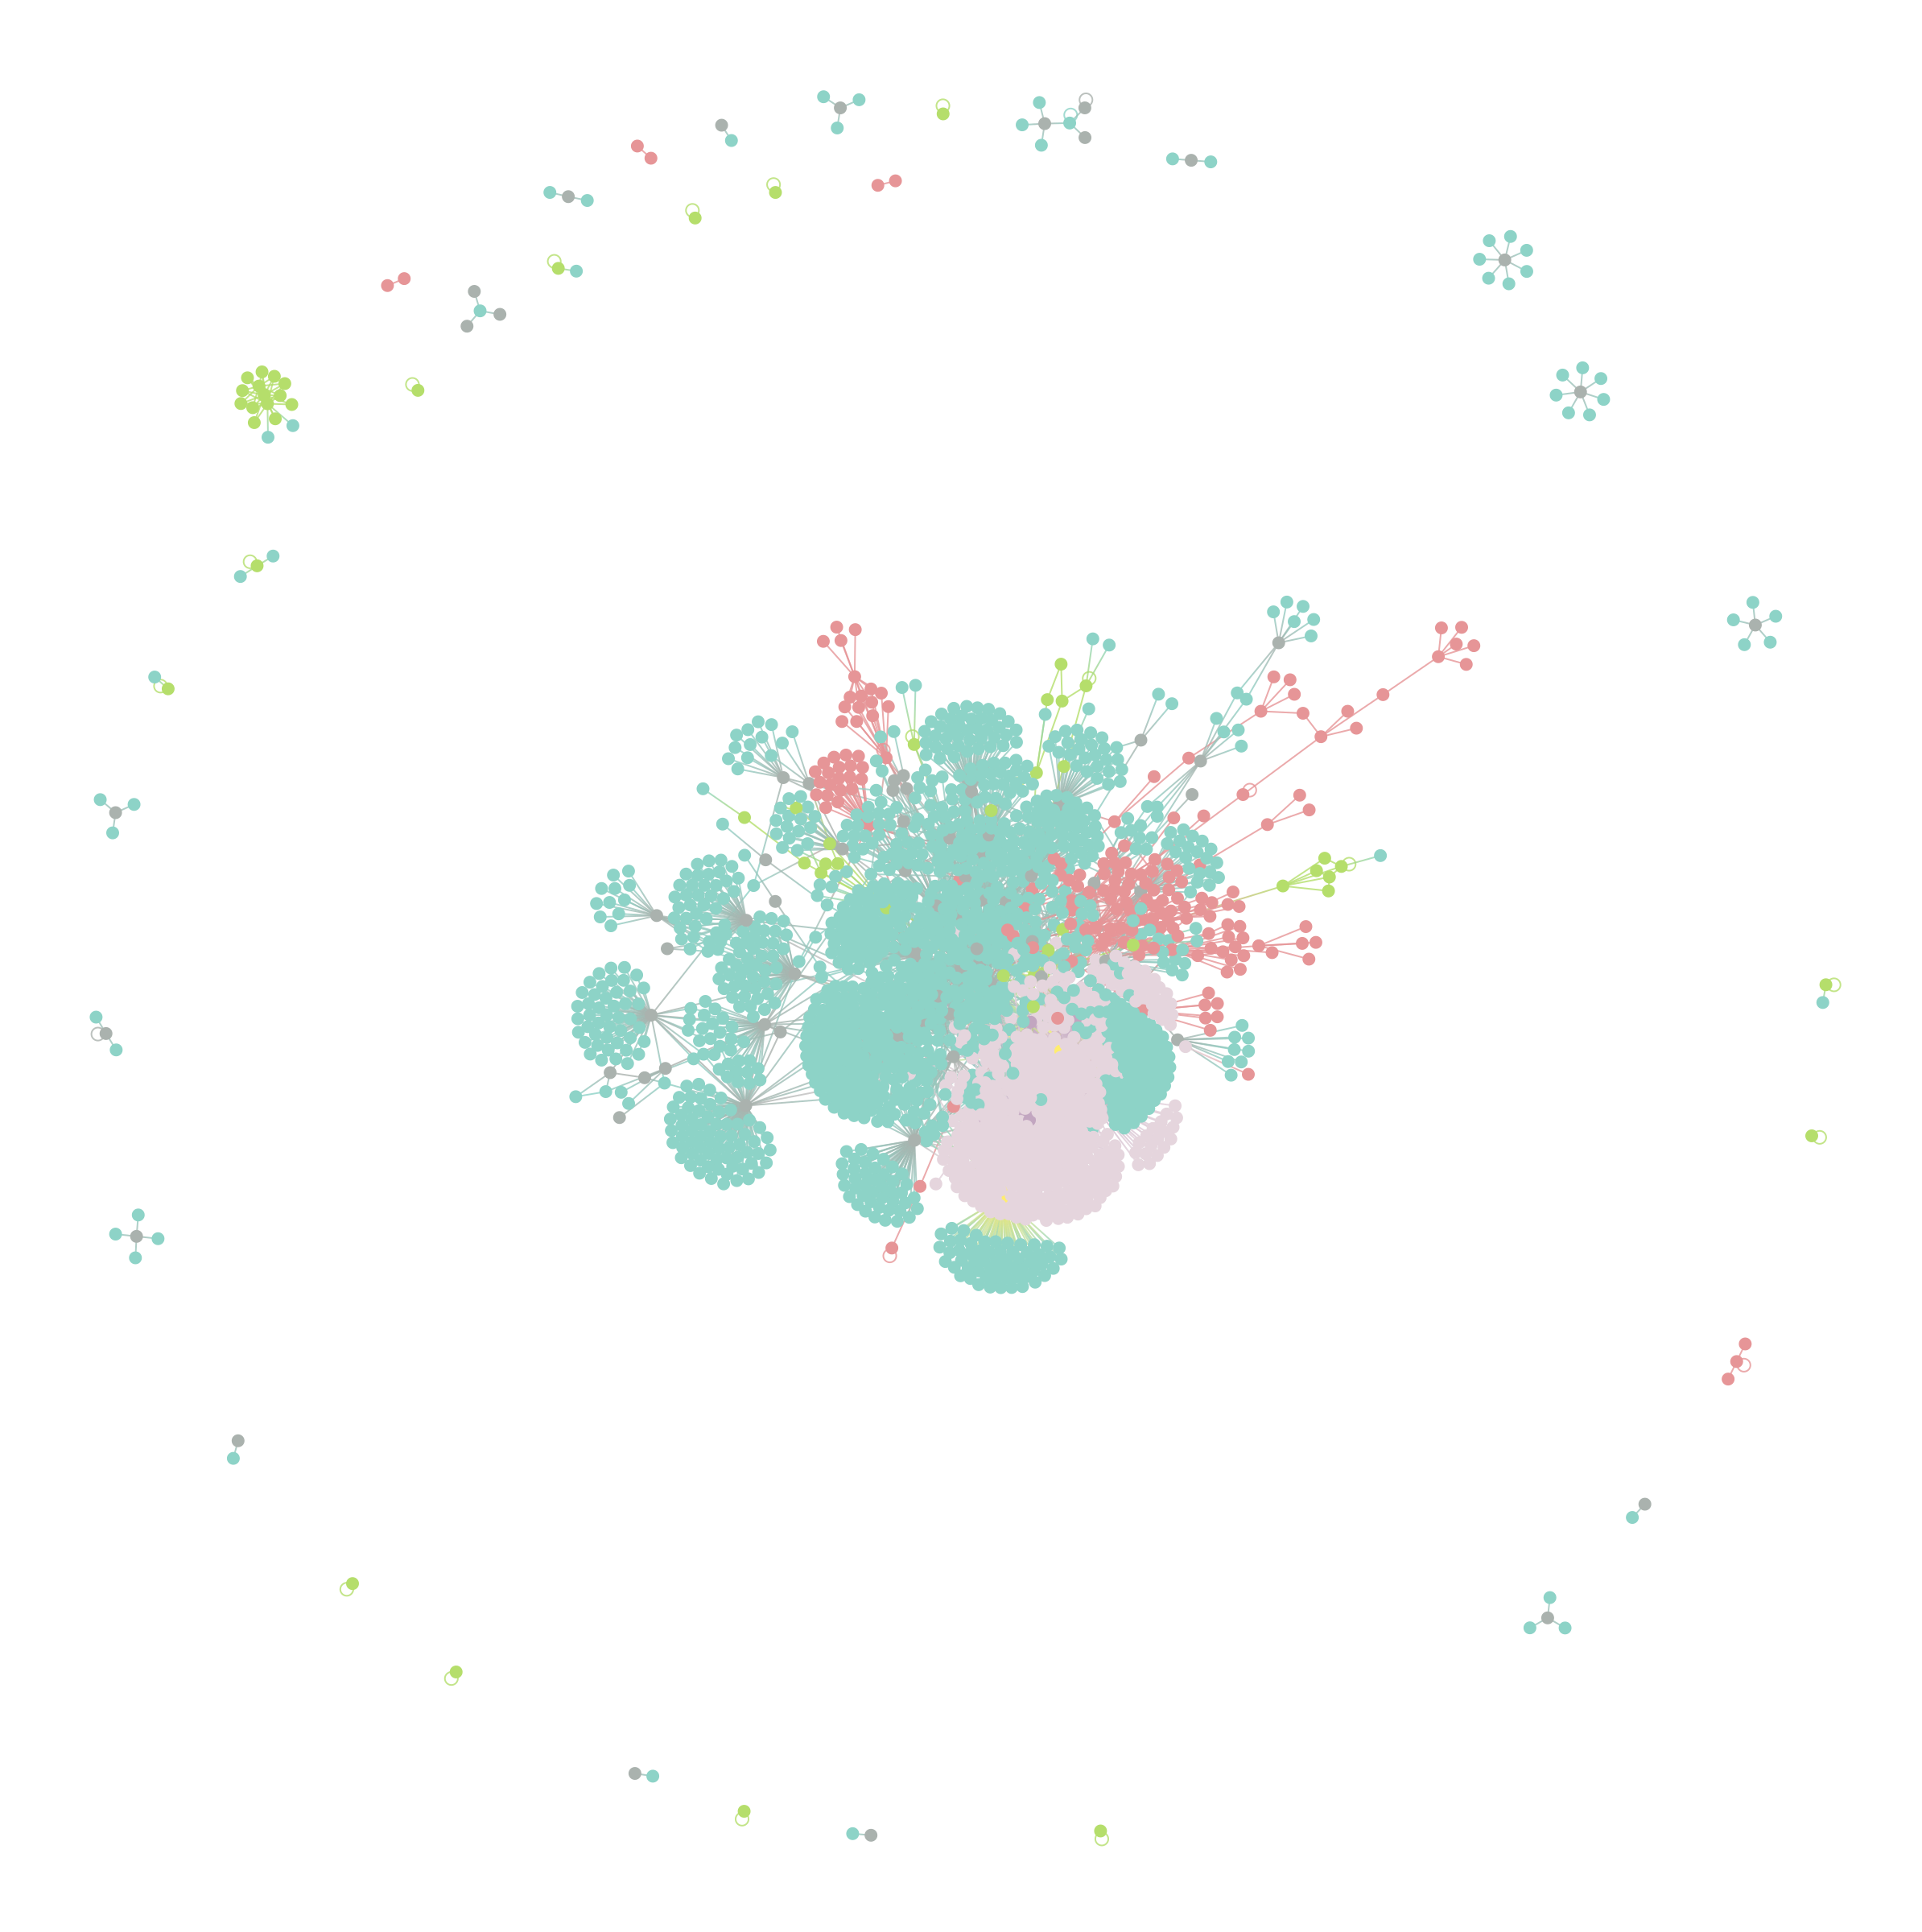

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f4bcf25b3d0, at 0x7f4bcf3f95b0>

In [11]:
# From NetworkX object To DOT (Graphviz format)
DOT1 = 'temp-prepared.dot'
nx_graph_l = cov_cx2.to_networkx()
nx.nx_agraph.write_dot(nx_graph_l, DOT1)

# Create a graph-tool network object　from DOT
gt_1 = load_graph(DOT1)

# Apply stochastic block model (SBM) to get graph partitions 
state = minimize_blockmodel_dl(gt_1)

# Draw the graph using the result above
state.draw(output_size=(1200, 1200), edge_pen_width=1)

In [12]:
# TODO: apply custom color palette from seaborn
pal1 = sns.color_palette()
list1 = state.get_blocks().get_array()
pal1

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [13]:
def get_color(idx):
    rgb = pal1[idx%10]
    return [rgb[0], rgb[1], rgb[2], 1]

In [14]:
# Export as image file
import matplotlib

# Apply SFDP layout
pos1 = sfdp_layout(gt_1)

# Generate PDF (vector)
graph_draw(gt_1, pos1, output_size=(1000, 1000), vertex_color=[10,1,1,0],
           vertex_size=2, edge_pen_width=0.2,
           vcmap=matplotlib.cm.gist_heat_r, output="covid2.pdf")

# Generate PNG (bitmap)
graph_draw(gt_1, pos1, output_size=(1000, 1000), vertex_color=[10,1,1,0],
           vertex_size=2, edge_pen_width=0.2,
           vcmap=matplotlib.cm.gist_heat_r, output="covid2.png")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f4bcf25b3d0, at 0x7f4c18062af0>

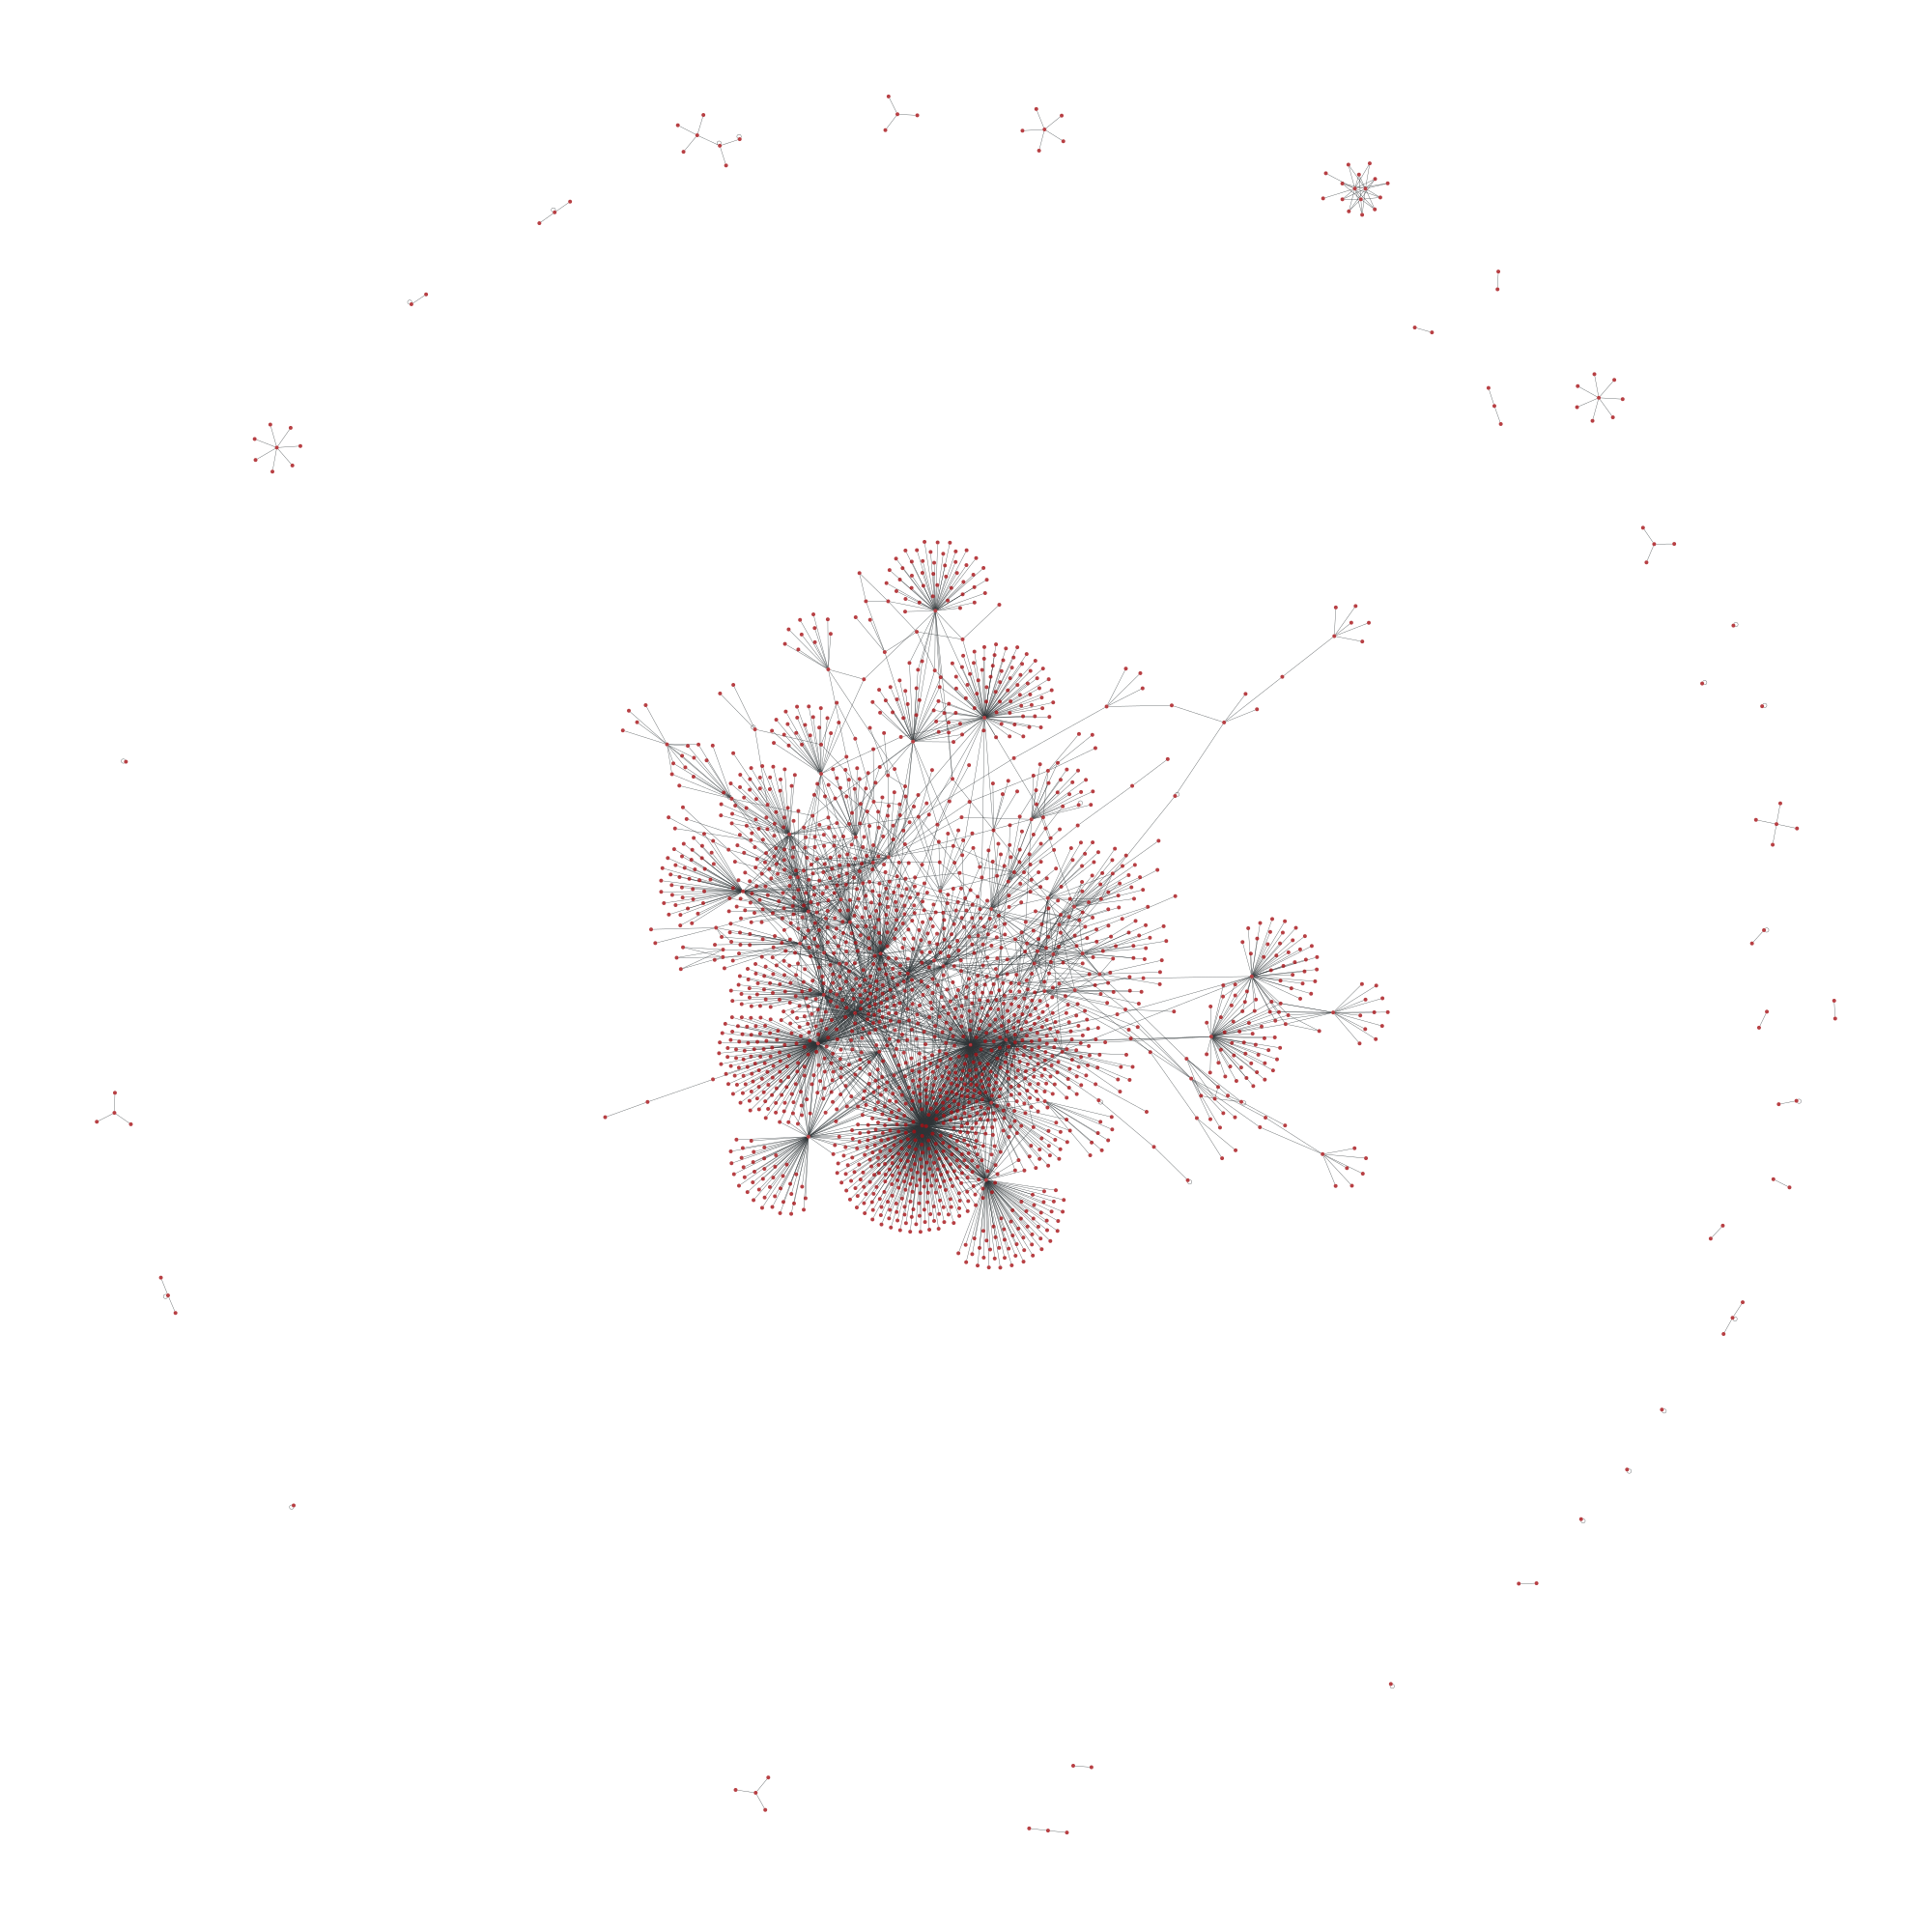

In [15]:
from IPython import display
display.Image("./covid2.png")

### graph-tool summary
- Great for large network analysis
- Styling is not easy to use

## Graph analysis with Networkit

### Pros
- Fast - large network analysis in mind
- Algorithms from relatively new papers are implemented
- Great library to implement your own algorithm in C++

### Cons
- No visualization function
    - Need to convert and draw in other libraries 

In [16]:
NEST_UUID = '60112105-f853-11e9-bb65-0ac135e8bacf'
response3 = nc2.get_network_as_cx_stream(NEST_UUID)
nest_cx = ndex2.create_nice_cx_from_raw_cx(json.loads(response3.content))

# Display information about network and output 1st 100 characters of CX
nest_cx.print_summary()

Name: Integrated association score (IAS) network, NeST project
Nodes: 8901
Edges: 100000
Node Attributes: 0
Edge Attributes: 800000



In [17]:
nest_nx = nest_cx.to_networkx()
nx.write_graphml(nest_nx, 'temp.graphml')
nkg = nk.readGraph('temp.graphml', nk.Format.GraphML)
nk.overview(nkg)

Network Properties:
nodes, edges			8901, 100000
directed?			False
weighted?			False
isolated nodes			0
self-loops			0
density				0.002525
clustering coefficient		0.460019
min/max/avg degree		1, 188, 22.469385
degree assortativity		0.660447
number of connected components	111
size of largest component	8095 (90.94 %)


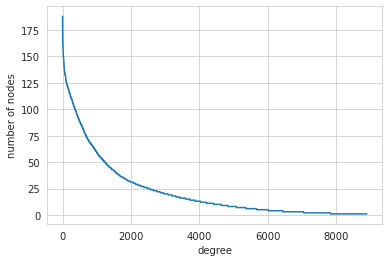

In [18]:
# Simple degree distribution plot
degree_dist = nk.centrality.DegreeCentrality(nkg).run().scores()
dd = sorted(degree_dist, reverse=True)
plt.xlabel("degree")
plt.ylabel("number of nodes")
plt.plot(dd)
plt.show()

In [19]:
com1 = nk.community.detectCommunities(nkg, algo=nk.community.PLM(nkg, True))

Communities detected in 0.01822 [s]
solution properties:
-------------------  ----------
# communities        143
min community size     2
max community size   878
avg. community size   62.2448
modularity             0.921232
-------------------  ----------


In [20]:
membership11 = com1.getMembers(10)
print(membership11)

{4146, 4147, 4148, 8245, 6208, 6209, 6210, 6225, 6226, 8282, 8291, 4221, 4222, 4223, 8320, 6294, 6295, 6296, 6297, 6298, 6299, 6300, 6301, 6302, 6303, 6304, 6305, 6306, 6307, 4260, 4264, 4265, 2223, 2224, 2225, 2226, 2227, 2228, 2229, 2230, 2231, 2232, 2233, 2234, 4296, 2258, 2259, 2260, 6378, 6379, 4354, 8455, 4361, 4362, 4363, 8478, 8489, 6448, 8496, 8499, 8513, 6468, 6490, 6491, 6492, 6493, 2399, 2408, 362, 363, 8569, 6523, 6524, 6525, 6526, 6527, 6528, 6529, 8584, 8585, 8586, 8587, 8588, 8589, 8590, 8591, 8592, 8593, 8594, 8595, 8596, 8605, 8606, 8618, 8627, 6583, 6584, 4541, 4542, 4543, 4544, 4546, 4547, 8663, 8664, 6623, 6624, 8681, 6641, 6642, 8696, 8697, 8709, 8728, 556, 557, 558, 559, 560, 4659, 4660, 4661, 4662, 4663, 4664, 4665, 2637, 2638, 2639, 2640, 2641, 2642, 2643, 5002, 2647, 2648, 2649, 2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 2658, 2659, 2660, 2661, 2662, 2663, 2664, 2665, 2666, 2667, 2668, 2669, 2670, 2671, 2672, 2673, 2674, 2675, 2676, 2677, 2678, 2679, 2680

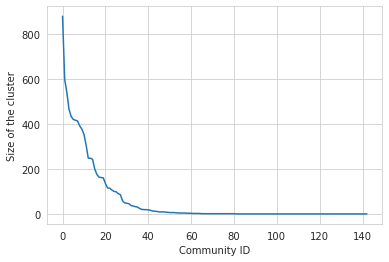

In [21]:
sizes = com1.subsetSizes()
sizes.sort(reverse=True)
plt.xlabel("Community ID")
plt.ylabel("Size of the cluster")
plt.plot(sizes)
plt.show()

----

# Interactrive Visualization

## ipycytoscape
- A simple library to embed Cytoscape.js instance in a cell

In [22]:
viz1 = ipycytoscape.CytoscapeWidget()
viz1.graph.add_graph_from_networkx(nx_graph)
viz1.set_layout(name='cose')
viz1

CytoscapeWidget(cytoscape_layout={'name': 'cose'}, cytoscape_style=[{'selector': 'node', 'css': {'background-c…

### Pros
- Simple
- Easy to use for small network visualization

### Cons
- No built-in support for visual style
- Interactivity
  - Editing style should be done manually (with Python coding)

In [23]:
# Use external service to generate style


In [24]:
# Convert the result to CX, and then convert to Cytoscape.js elements and Visual Style
import requests as rq

# Convert to CX as dict
MUSIC_ID = '7fc70ab6-9fb1-11ea-aaef-0ac135e8bacf'
response3 = nc2.get_network_as_cx_stream(MUSIC_ID)
cov_cx3 = ndex2.create_nice_cx_from_raw_cx(json.loads(response3.content))
cx3 = cov_cx3.to_cx()

headers = {"charset": "utf-8", "Content-Type": "application/json"}
res = rq.post("http://network-api:3000/cx", json=cx3, headers=headers)
cyjs_json = res.json()

viz2 = ipycytoscape.CytoscapeWidget()
viz2.graph.add_graph_from_json(cyjs_json['elements'])
viz2.set_layout(name='preset')
viz2.set_style(cyjs_json['style'])
viz2

Generating CX


CytoscapeWidget(cytoscape_layout={'name': 'preset'}, cytoscape_style=[{'selector': 'node', 'css': {'text-wrap'…

## Data-Driven styling

### Limitation
Currently, there is no high-level, interactive toolkit to generate data-driven styles

- What kind of features do we need?




- A bit weired API (from Python programmer's point of view, because it was originally optyimized for R)
# Interactive Dashboards with Plotly Dash

## What's Dash?
- An open source project 
- The basic function of Dash is building an web application for data dashboard
- VERY high-level API
    - You can create basic visualization/ UI components withwout writing JavaScript code 

## What's JupyterDash?
- You can embed an interactive application as a cell/panel in Jupyter Lab
- Great integration to existing notebooks

## What's Dash Cytoscape?
- A Cytoscape.js-based visualization library
- Can be controlled by Python code


### As far as I know, this is the best combination to create interactive network images embedded in the notebook environment

In [25]:
# Import Dash-related dependencies
from jupyter_dash import JupyterDash
import dash
from dash import html
import dash_daq as daq
import dash_cytoscape as cyto

# UI components for Dash
from dash import dcc
from dash.dependencies import Input, Output

# enable svg export
cyto.load_extra_layouts()

elements = cyjs_json['elements']
visual_style = cyjs_json['style']

vs_updated = []
for entry in visual_style:
    vs_updated.append({
        'selector': entry['selector'],
        'style': entry['css']
    })    

In [30]:
app = JupyterDash(__name__)

# For layout selector
layout_names = [
    {"label": "Preset", "value": "preset"},
    {"label": "Circle", "value": "circle"},
    {"label": "COSE", "value": "cose"},
    {"label": "Breadth-First", "value": "breadthfirst"}
]

layout_selector_style = {"margin-bottom": "1em"}

cyto_cp = cyto.Cytoscape(
    id="cyto-cp",
    style={"width": "100%", "height": "800px", "background": '#EFEFEF'},
    elements=elements,
    layout={"name": "preset"},
    stylesheet=vs_updated
)

app.layout = html.Div(
    [
        html.H2("CX Network in Dash"),
        html.P("BG Color widget example"),
        dcc.Slider(
            id='color-slider',
            min=0,
            max=255,
            step=1,
            value=255,
        ),
        html.Div(id='slider-output-container'),
        dcc.Dropdown(
            id="layout-selector",
            options=layout_names,
            value='preset',
            style=layout_selector_style
        ),
        cyto_cp,
        html.Div('Download network image as:'),
        dcc.Dropdown(
            id="image-type-selector",
            options=[{"label": "SVG", "value": "svg"}, {"label": "PNG", "value": "png"}],
            value='png',
        ),
        html.Button("Download", id="btn-get-svg")
    ]
)

# Callback function for interaction
@app.callback(
    Output("cyto-cp", "layout"),
    [Input("layout-selector", "value")],
)
def update_layout(layout_name):
    new_layout = {
        "name": layout_name,
        "animate": True,
    }

    return new_layout

@app.callback(
    Output("cyto-cp", "generateImage"),
    [
        Input("btn-get-svg", "n_clicks"),
    ])
def get_image(get_svg_clicks):

    ftype = 'svg'

    # 'store': Stores the image data in 'imageData' !only jpg/png are supported
    # 'download'`: Downloads the image as a file with all data handling
    # 'both'`: Stores image data and downloads image as file.
    action = 'download'

    ctx = dash.callback_context
    if ctx.triggered:
        return {
            'type': ftype,
            'action': action
        }
    else:
        return {
        }


@app.callback(
    dash.dependencies.Output('cyto-cp', 'style'),
    [dash.dependencies.Input('color-slider', 'value')])
def update_size(color):
    new_style = {
        "width": "100%",
        "height": "800px", 
        "background": "rgba(" + str(color) +',' + str(color) + ',' + str(color) + ',200)'
    }
    
    return new_style


# Activate
app.run_server(mode='jupyterlab', host="0.0.0.0", port=8050, dev_tools_ui=True)

# Discussion
## What are the missing links to create smooth workflow?

- Style Conversion from CX
- **Portable Style**
- Custom Dash component for typical use
    - Layout selector
    - **Style Editor**
        - Mappings

# Summary

## Recommendations for task types

### Data Format Conversion / Data Wrangling
    - NetworkX
    - Pandas
    
### Graph Analysis
    - graph-tool
    - Networkit
    - igraph

### Visualization
    - graph-tool

### Interactive visualization
    - Dash Cytoscape
    

# TODO
- How can we pass the style information around?